In [ ]:
!ls ../input/waldotest

cropped_image.jpeg	    original_background_7.jpg
cropped_image_2.jpg	    wally_background.png
original_background_13.jpg  wally_image_transparent.png
original_background_18.jpg  wenda_image_transparent.png
original_background_3.jpg



[Original Medium Article for Reference](https://medium.com/analytics-vidhya/finding-waldo-using-a-simple-convolutional-neural-network-1604cb4d2e55)

## Imports and Data Preview

In [ ]:
#first import libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
import os

#tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model

#import time
import time

In [ ]:
image_dir = '../input/waldotest'

#get the background and waldo image directory
# background_dir = image_dir + '/wally_background.png'
background_dir = image_dir + '/cropped_image_2.jpg'
waldo_dir = image_dir + '/wally_image_transparent.png'
wilma_dir = image_dir + '/wenda_image_transparent.png'

In [ ]:
def generate_background_images(image_path:str, x_size:int=500, y_size:int=350, counter=[1]):
#     x-------> width = row
#     y|        height = col
#      v
    full_background_im = Image.open(image_path)
    width, height = full_background_im.size
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, height-y_size)
    row = np.random.randint(0, width-x_size)
#     (left, top, right, bottom)
    new_image=full_background_im.crop((row,col,row+x_size, col+y_size))
    new_image.save(f"new_image_{counter[0]}.png")
    counter[0]+=1
    
generate_background_images("../input/waldotest/original_background_7.jpg")

### Background Image and Waldo

../input/waldotest/cropped_image_2.jpg


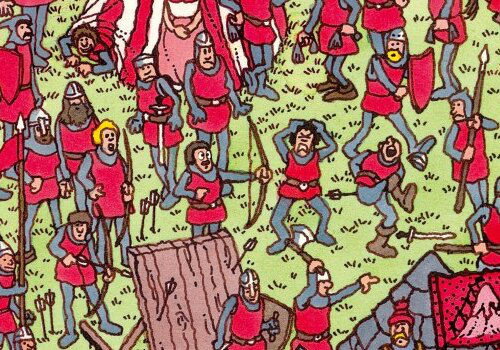

In [ ]:
#background image
print(background_dir)
background_im = Image.open(background_dir)
background_im

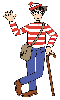

In [ ]:
#image of waldo
waldo_im = Image.open(waldo_dir)
waldo_im = waldo_im.resize((60, 100))
waldo_im

In [ ]:
BACKGROUND_IMG=Image.open(background_dir).resize((500, 350))
WALDO_IMAGE=Image.open(waldo_dir).convert("RGBA").resize((60, 100))
#create a function to generate images
def generate_sample_image(background=BACKGROUND_IMG):
    """
    A function that generates sample images by inserting Waldo into the random
    location on the backround image
    """
    
    #background image
    background_im = background.copy()
    #background_im = Image.new("RGB", (500, 350), (255, 255, 255))
    
    #select x and y coordinates randomly we'll select between (0, 430) and (0, 250)
    col = np.random.randint(0, 410)
    row = np.random.randint(0, 230)
    
    
    background_im.paste(WALDO_IMAGE, (col, row), mask = WALDO_IMAGE)
        
    return np.array(background_im).astype('uint8'), (col, row)

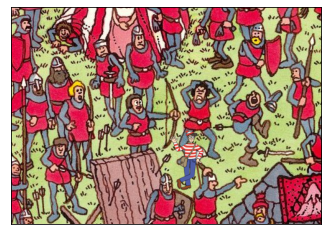

In [ ]:
#generate the sample image and plot
sample_im, pos = generate_sample_image()
plt.imshow(sample_im)
plt.xticks([])
plt.yticks([])
plt.show()

Notice how Waldo got inserted into a random location on the image

In [ ]:
def plot_bounding_box(image, gt_coords, pred_coords = None):
    """
    A helper function to visualize the bounding box(what we are trying to predict)
    """
    
    #convert image to array
    image = Image.fromarray(image)    
    draw = ImageDraw.Draw(image)
    draw.rectangle((gt_coords[0], gt_coords[1], gt_coords[0] + 60, gt_coords[1] + 100), outline = 'green', width = 5)
    
    if pred_coords:
        
        draw.rectangle((pred_coords[0], pred_coords[1], pred_coords[0] + 60, pred_coords[1] + 100), outline = 'red', width = 5)
    
    return image

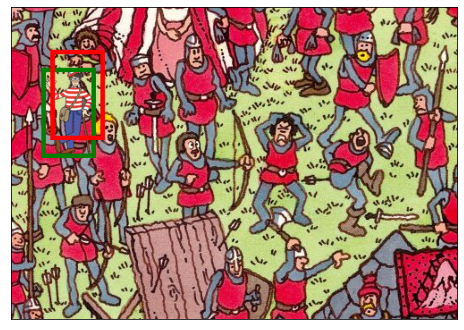

In [ ]:
#generate an example image
sample_im, pos = generate_sample_image()

#get image with bounding box
im = plot_bounding_box(sample_im, pos, (pos[0] + 10, pos[1] -20))

plt.figure(figsize = (8, 8))
plt.imshow(im)
plt.xticks([])
plt.yticks([])
plt.show()

For now, the boxes position. After the models are trained, green color is the desired boundary box, while red color indicated the prediction.

In [ ]:
#data generator function 
def generate_data(batch_size = 16):
    """
    A generator that yields data for training
    """
    
    while True:
        
        #create empty arrays for the generated data
        x_batch = np.zeros((batch_size, 350, 500, 3))
        y_batch = np.zeros((batch_size, 1))
        boundary_box = np.zeros((batch_size, 2))
        
        for i in range(batch_size):
            
            #generate an example image
            sample_im, pos = generate_sample_image()
            
            #put the images to the arrays
            x_batch[i] = sample_im/255 #normalize
            boundary_box[i, 0] = pos[0]
            boundary_box[i, 1] = pos[1]
            
        #yield {'image': x_batch} , {'class': y_batch, 'box': boundary_box}
        yield {'input': x_batch} , {'box': boundary_box} 

## Model 1

In [ ]:
def convolutional_block(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

2022-12-17 22:53:44.476563: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 22:53:44.586340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 22:53:44.587136: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 22:53:44.589068: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

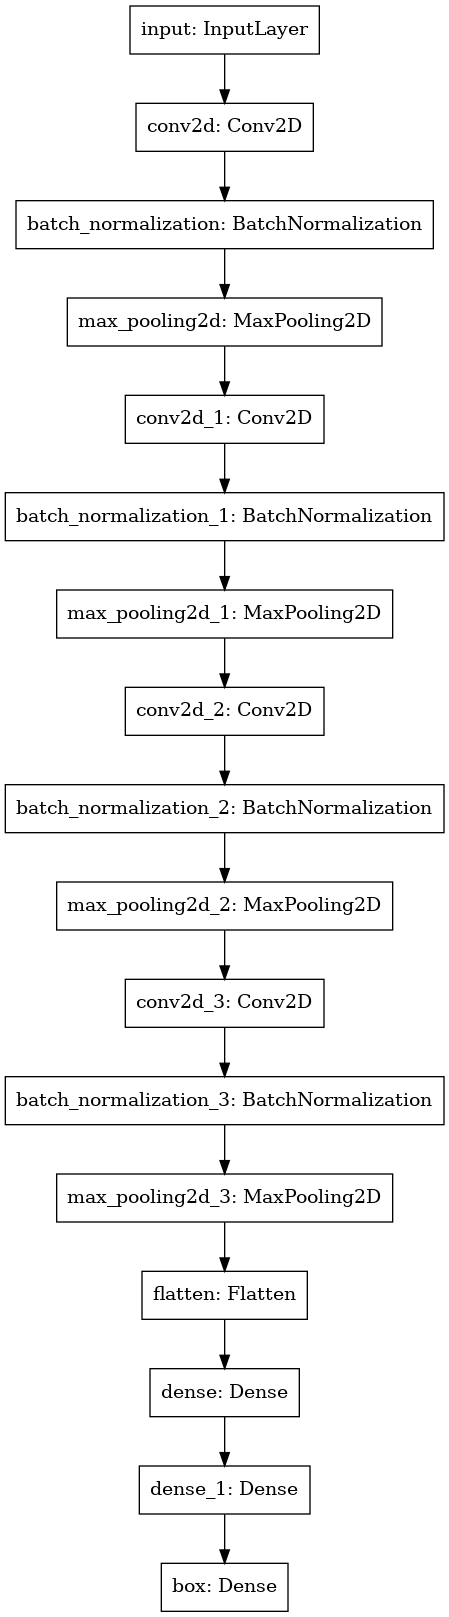

In [ ]:
#create the model instance
inputs = tf.keras.Input((350, 500, 3))

#conv block
x = convolutional_block(inputs)

#outputs
box_output = regression_block(x)

#model instance
model = tf.keras.Model(inputs = inputs, outputs = [box_output], name='Model_1')
model.layers[0]._name="input"

#plotting the model architechture
plot_model(model)

In [ ]:
#model summary
model.summary()

Model: "Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 350, 500, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 350, 500, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 350, 500, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 175, 250, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 175, 250, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 175, 250, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 87, 125, 32)       0   

In [ ]:
#custom function to visualize the predictions after epochs
def test_model(background=BACKGROUND_IMG, model=model):
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))    
    
    for i in range(3):
        
        #get sample image
        sample_im, pos, = generate_sample_image(background)
        sample_image_normalized = sample_im.reshape(1, 350, 500, 3)/255
        predicted_box = model.predict(sample_image_normalized)
        
        #get bounding boxes
        im = plot_bounding_box(sample_im, pos, (predicted_box[0][0], predicted_box[0][1]))
        
        #plot image
        ax[i].imshow(im)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        
    plt.show()
        
# visualize the training results every 2nd epoch
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model(model=model)
            
#learning rate scheduleer
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

In [ ]:
#compile
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'box': 'mse'}, \
              metrics = { 'box': 'mse'})

/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
2022-12-17 22:53:49.009241: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-12-17 22:53:49.983084: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 22s 144ms/step - loss: 5174.8379 - mse: 5174.8379


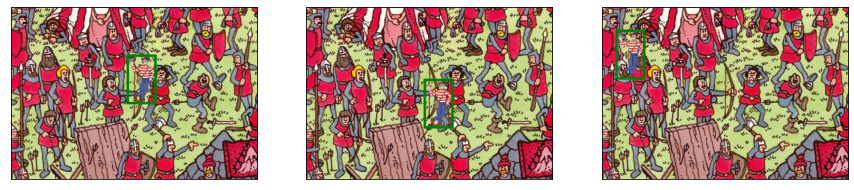

Epoch 2/15
100/100 [==============================] - 14s 138ms/step - loss: 142.6936 - mse: 142.6936
Epoch 3/15
100/100 [==============================] - 14s 138ms/step - loss: 59.2114 - mse: 59.2114


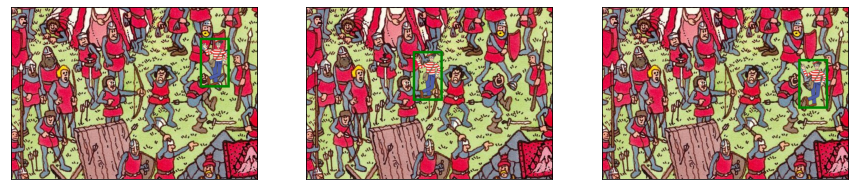

Epoch 4/15
100/100 [==============================] - 14s 143ms/step - loss: 69.0526 - mse: 69.0526
Epoch 5/15
100/100 [==============================] - 14s 142ms/step - loss: 26.3722 - mse: 26.3722


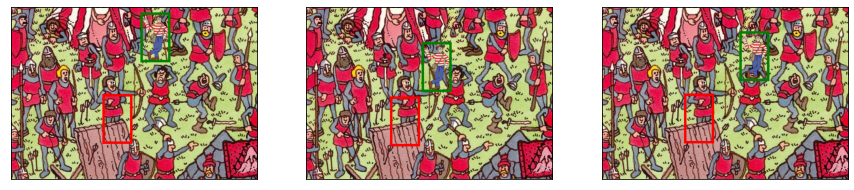

Epoch 6/15
100/100 [==============================] - 14s 145ms/step - loss: 19.7285 - mse: 19.7285
Epoch 7/15
100/100 [==============================] - 14s 141ms/step - loss: 16.5689 - mse: 16.5689


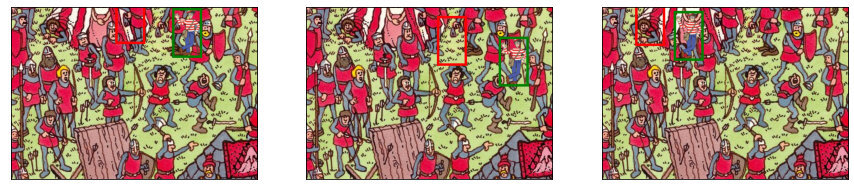

Epoch 8/15
100/100 [==============================] - 14s 145ms/step - loss: 16.3466 - mse: 16.3466
Epoch 9/15
100/100 [==============================] - 14s 139ms/step - loss: 13.7387 - mse: 13.7387


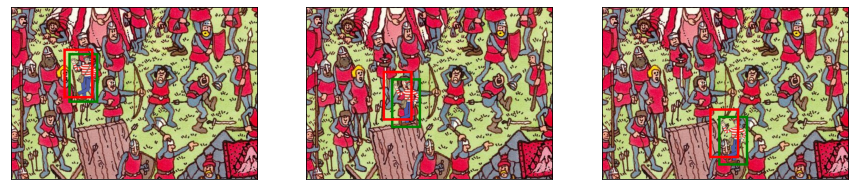

Epoch 10/15
100/100 [==============================] - 14s 142ms/step - loss: 12.7718 - mse: 12.7718
Epoch 11/15
100/100 [==============================] - 14s 141ms/step - loss: 10.3717 - mse: 10.3717


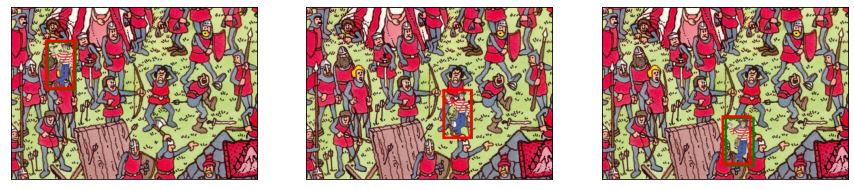

Epoch 12/15
100/100 [==============================] - 14s 143ms/step - loss: 11.0275 - mse: 11.0275
Epoch 13/15
100/100 [==============================] - 14s 139ms/step - loss: 11.0522 - mse: 11.0522


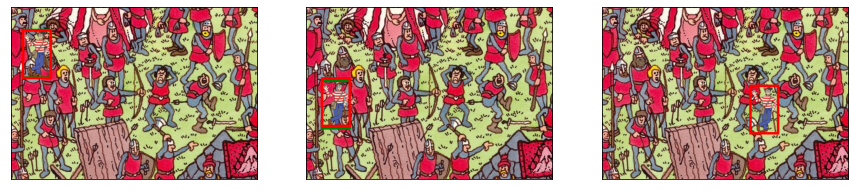

Epoch 14/15
100/100 [==============================] - 14s 138ms/step - loss: 10.6353 - mse: 10.6353
Epoch 15/15
100/100 [==============================] - 15s 147ms/step - loss: 9.3666 - mse: 9.3666


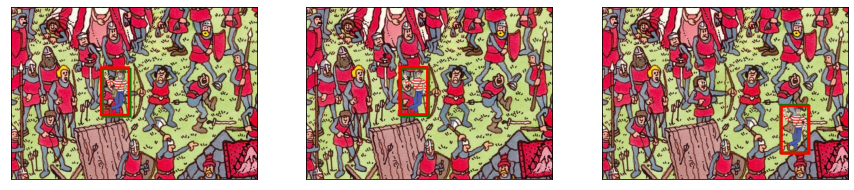

it took 262.1817 s to train the model


In [ ]:
tf.config.run_functions_eagerly(True)
#beginning time
tick = time.time()

#fit the model
hist = model.fit(generate_data(), epochs = 15, steps_per_epoch = 100, callbacks = [VisCallback(),\
                                                                           tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()
print(f'it took {(tock-tick):.4f} s to train the model')

#save model weights
model.save_weights('./model_1.ckpt')

## Model 2
The main difference is that it has one more regression layer with 2048 neurons compared to model 1

In [ ]:
#create the model
def convolutional_block2(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
        
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    return x

def regression_block2(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x) # NEW LAYER
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x

#create the model instance
inputs2 = tf.keras.Input((350, 500, 3))

#conv block
x2 = convolutional_block2(inputs2)

#outputs
box_output2 = regression_block2(x2)

#model instance
model2 = tf.keras.Model(inputs = inputs2, outputs = [box_output2], name='Model_2')
model2.layers[0]._name="input"

#plotting the model architechture
plot_model(model2)
#model summary
print(model2.summary())

Model: "Model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 350, 500, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 350, 500, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 350, 500, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 175, 250, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 175, 250, 32)      4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 175, 250, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 87, 125, 32)       0   

In [ ]:
#compile
model2.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'box': 'mse'}, \
              metrics = { 'box': 'mse'})


Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


100/100 [==============================] - 15s 149ms/step - loss: 4675.9126 - mse: 4675.9126


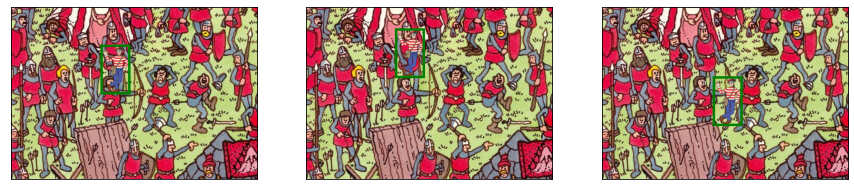

Epoch 2/15
100/100 [==============================] - 14s 141ms/step - loss: 93.0380 - mse: 93.0380
Epoch 3/15
100/100 [==============================] - 15s 147ms/step - loss: 59.2717 - mse: 59.2717


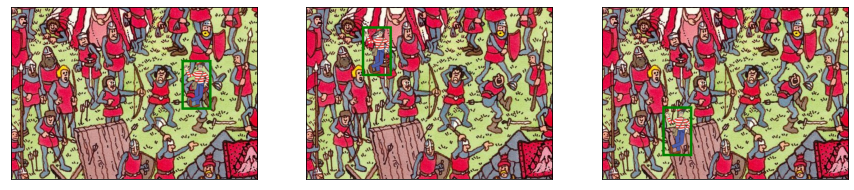

Epoch 4/15
100/100 [==============================] - 14s 143ms/step - loss: 69.9671 - mse: 69.9671
Epoch 5/15
100/100 [==============================] - 15s 146ms/step - loss: 26.5677 - mse: 26.5677


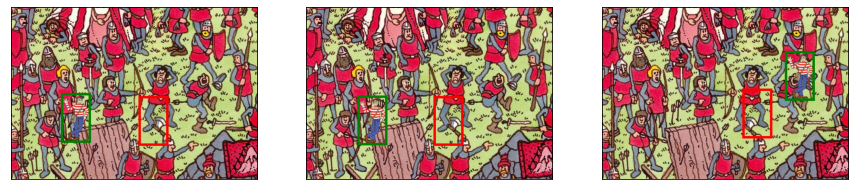

Epoch 6/15
100/100 [==============================] - 14s 143ms/step - loss: 9.7221 - mse: 9.7221
Epoch 7/15
100/100 [==============================] - 14s 142ms/step - loss: 9.6639 - mse: 9.6639


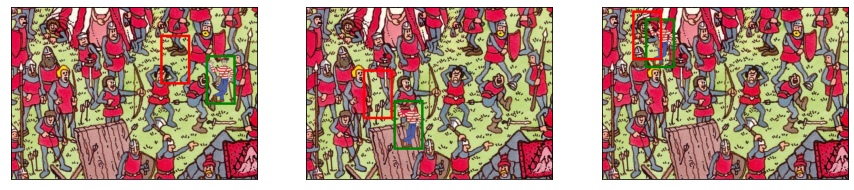

Epoch 8/15
100/100 [==============================] - 15s 146ms/step - loss: 11.4171 - mse: 11.4171
Epoch 9/15
100/100 [==============================] - 14s 142ms/step - loss: 9.5681 - mse: 9.5681


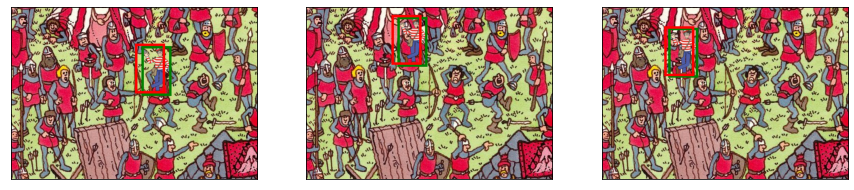

Epoch 10/15
100/100 [==============================] - 15s 146ms/step - loss: 6.7263 - mse: 6.7263
Epoch 11/15
100/100 [==============================] - 14s 141ms/step - loss: 6.5358 - mse: 6.5358


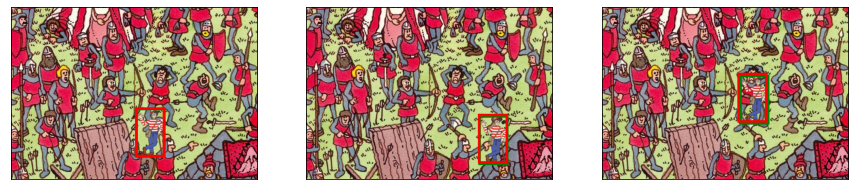

Epoch 12/15
100/100 [==============================] - 15s 149ms/step - loss: 6.4565 - mse: 6.4565
Epoch 13/15
100/100 [==============================] - 14s 141ms/step - loss: 6.1526 - mse: 6.1526


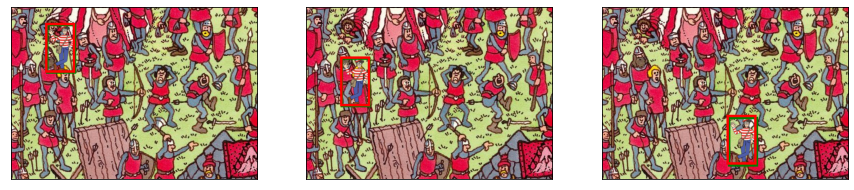

Epoch 14/15
100/100 [==============================] - 15s 146ms/step - loss: 6.8558 - mse: 6.8558
Epoch 15/15
100/100 [==============================] - 14s 140ms/step - loss: 5.0241 - mse: 5.0241


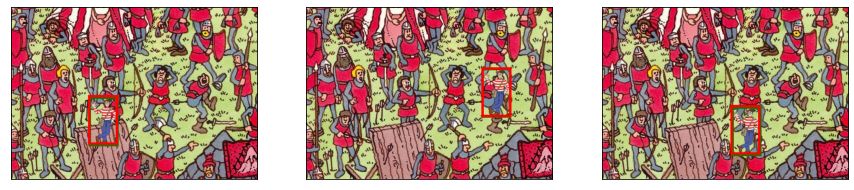

it took 262.0575 s to train the model


In [ ]:
# redefine the callback to work with model2
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model(model=model2)

tf.config.run_functions_eagerly(True)
#beginning time
tick = time.time()

#fit the model
hist = model2.fit(generate_data(), epochs = 15, steps_per_epoch = 100, callbacks = [VisCallback(),\
                                                                           tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()
print(f'it took {(tock-tick):.4f} s to train the model')

#save model weights
model2.save_weights('./model_2.ckpt')

Notice that the green box is barely noticable, indicating how well the model is performing on the test data
## Model 3
The additional regression layer is still being kept, while 1 convolutional layer has been removed

In [ ]:
def convolutional_block3(inputs):
    
    x = tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu', name='input')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
    x = tf.keras.layers.Conv2D(64, 6, padding = 'valid', activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(2)(x)
    
#     REMOVED CONVOLUTIONAL LAYER
    
    return x


def regression_block3(x):
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation = 'relu')(x) # new layer
    x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(2, name = 'box')(x)
    
    return x


#create the model instance
inputs3 = tf.keras.Input((350, 500, 3))

#conv block
x3 = convolutional_block3(inputs3)

#outputs
box_output3 = regression_block3(x3)

#model instance
model3 = tf.keras.Model(inputs = inputs3, outputs = [box_output3], name='Model_3')
model3.layers[0]._name="input"

#plotting the model architechture
plot_model(model3)
#model summary
print(model3.summary())

Model: "Model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 350, 500, 3)]     0         
_________________________________________________________________
input (Conv2D)               (None, 350, 500, 16)      448       
_________________________________________________________________
batch_normalization_8 (Batch (None, 350, 500, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 175, 250, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 175, 250, 32)      4640      
_________________________________________________________________
batch_normalization_9 (Batch (None, 175, 250, 32)      128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 87, 125, 32)       0   

In [ ]:
#compile
model3.compile(optimizer = tf.keras.optimizers.Adam(), loss = {'box': 'mse'}, \
              metrics = { 'box': 'mse'})

Epoch 1/15


/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:4212: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


100/100 [==============================] - 14s 139ms/step - loss: 28499.8145 - mse: 28499.8145


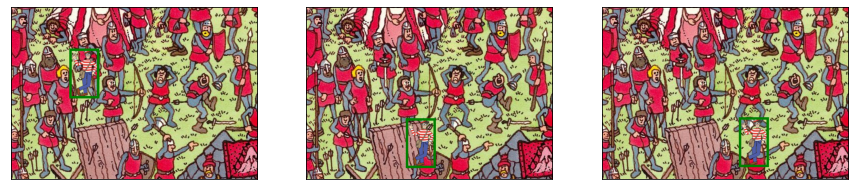

Epoch 2/15
100/100 [==============================] - 14s 137ms/step - loss: 439.8378 - mse: 439.8378
Epoch 3/15
100/100 [==============================] - 14s 140ms/step - loss: 131.7228 - mse: 131.7228


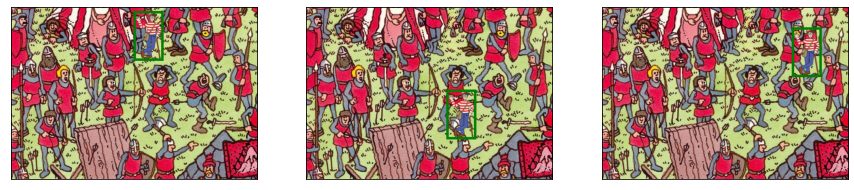

Epoch 4/15
100/100 [==============================] - 14s 138ms/step - loss: 67.6199 - mse: 67.6199
Epoch 5/15
100/100 [==============================] - 14s 140ms/step - loss: 20.1150 - mse: 20.1150


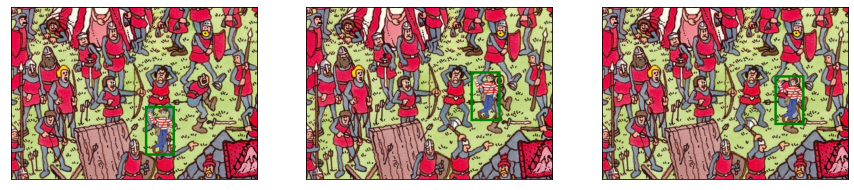

Epoch 6/15
100/100 [==============================] - 13s 135ms/step - loss: 15.5877 - mse: 15.5877
Epoch 7/15
100/100 [==============================] - 14s 138ms/step - loss: 17.9804 - mse: 17.9804


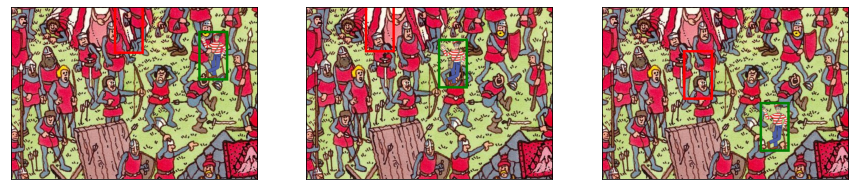

Epoch 8/15
100/100 [==============================] - 14s 137ms/step - loss: 14.6027 - mse: 14.6027
Epoch 9/15
100/100 [==============================] - 14s 139ms/step - loss: 14.2178 - mse: 14.2178


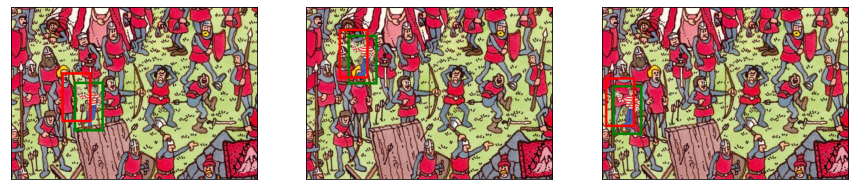

Epoch 10/15
100/100 [==============================] - 14s 137ms/step - loss: 10.3841 - mse: 10.3841
Epoch 11/15
100/100 [==============================] - 14s 136ms/step - loss: 9.7771 - mse: 9.7771


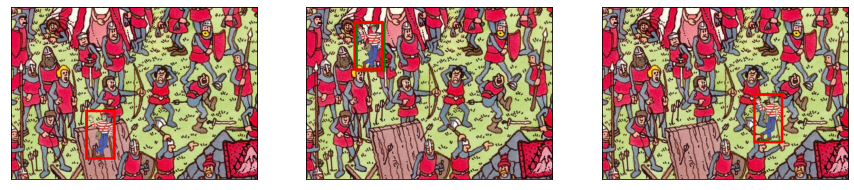

Epoch 12/15
100/100 [==============================] - 14s 140ms/step - loss: 8.9693 - mse: 8.9693
Epoch 13/15
100/100 [==============================] - 14s 138ms/step - loss: 10.1310 - mse: 10.1310


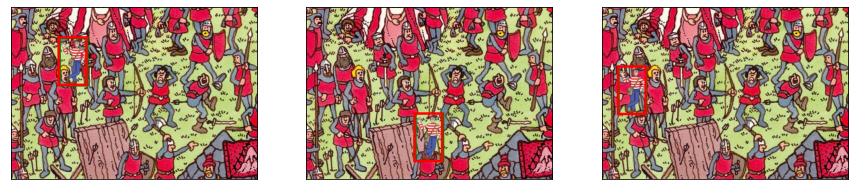

Epoch 14/15
100/100 [==============================] - 14s 141ms/step - loss: 8.9850 - mse: 8.9850
Epoch 15/15
100/100 [==============================] - 14s 137ms/step - loss: 8.0663 - mse: 8.0663


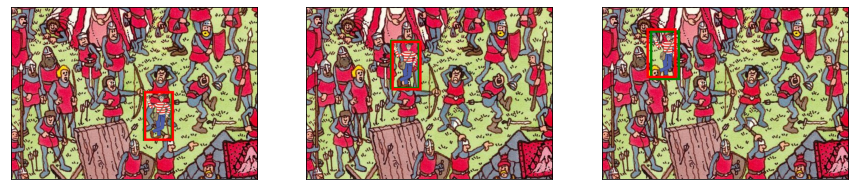

it took 210.5705 s to train the model


2022-12-17 23:06:06.977806: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289748480 exceeds 10% of free system memory.
2022-12-17 23:06:08.046613: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289748480 exceeds 10% of free system memory.
2022-12-17 23:06:09.109728: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289748480 exceeds 10% of free system memory.


In [ ]:
# redefine the callback to work with model3
class VisCallback(tf.keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs = None):
        
        if epoch % 2 == 0:
            
            test_model(model=model3)

tf.config.run_functions_eagerly(True)
#beginning time
tick = time.time()

#fit the model
hist = model3.fit(generate_data(), epochs = 15, steps_per_epoch = 100, callbacks = [VisCallback(),\
                                                                           tf.keras.callbacks.LearningRateScheduler(lr_schedule)])

#end time
tock = time.time()

#end time
tock = time.time()
print(f'it took {(tock-tick):.4f} s to train the model')

#save model weights
model3.save_weights('./model_3.ckpt')

Notice that compared to Model 2, MSE is higher for model 3. Additionally, you can clearly see the discrepancy between green and red boxes. Clearly, model 2 is superior compared to model 3 and 1.
## Test models on a different input(3 times per each one)
Still, it might be a good idea to check how each model is performing on the completely new background. For that sake, we'll generate a new image on the new background 9 times per model and visualize the results.

Model 1 on a different image:


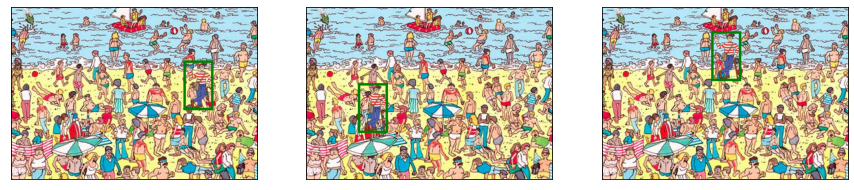

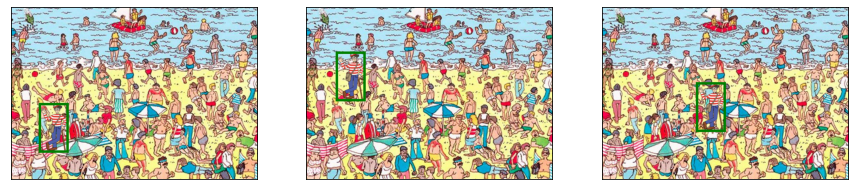

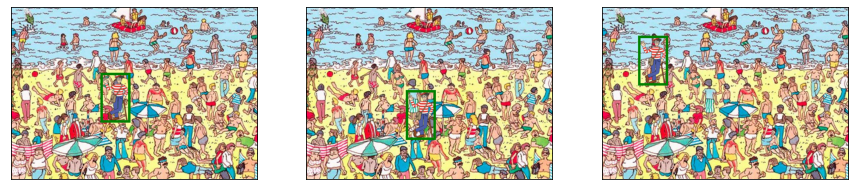

Model 2 on a different image:


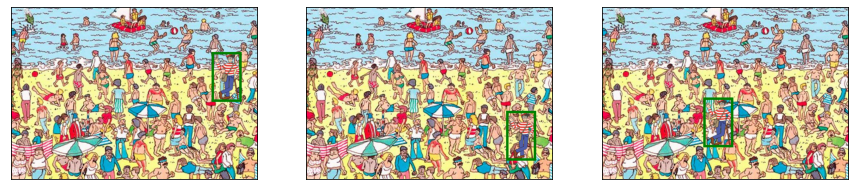

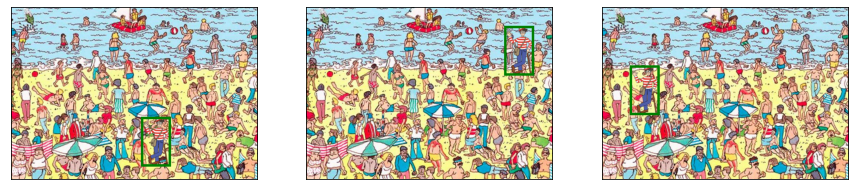

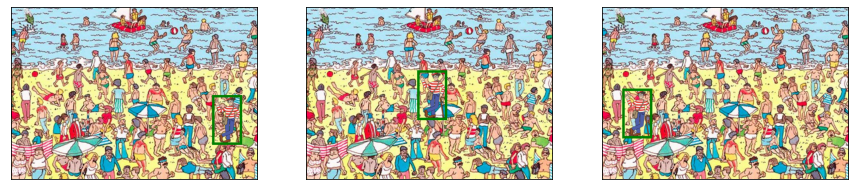

Model 3 on a different image:


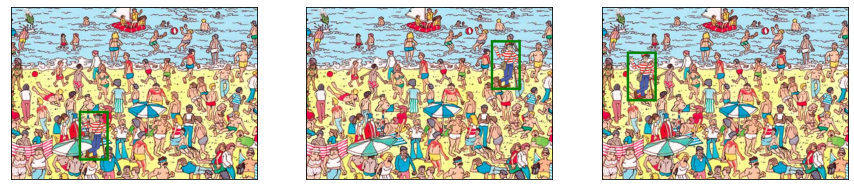

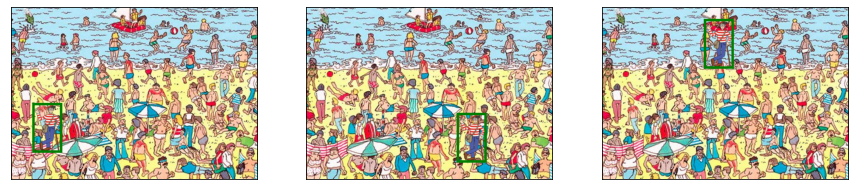

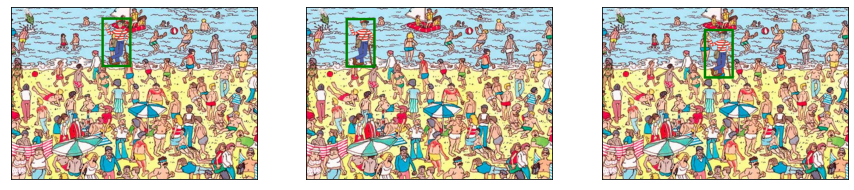

In [ ]:
new_background=Image.open(image_dir + '/wally_background.png').resize((500, 350))
print('Model 1 on a different image:')
for i in range(3):
    test_model(background=new_background, model=model)

print('Model 2 on a different image:')
for i in range(3):
    test_model(background=new_background, model=model2)
    
print('Model 3 on a different image:')
for i in range(3):
    test_model(background=new_background, model=model3)

As you can see, the models are not performing too well on the new background. The probable cause is severe overfitting, which hinders models performances. In order to mitigate this problem, it might be possible to train each model on multiple backrounds to make sure the overfitting is not that severe